## JSR-223 Script Engine Microbenchmarks

[JMH](http://hg.openjdk.java.net/code-tools/jmh) benchmarks for JSR-223 script engines using [GraalVM](https://www.graalvm.org/) EE.
Followed engines were compared: Rhino (JavaScript), Nashorn (JavaScript), Groovy (Groovy), Jython (Python), GraalJS (JavaScript).

**System Configuration**:

OS: Ubuntu 18.04<br>

Processor: Intel(R) Core(TM) i5-6200U CPU @ 2.30GHz x 4<br>

RAM: 8 GB

Java:<br>

`openjdk version "1.8.0_212"
Java(TM) SE Runtime Environment (build 1.8.0_212-b31)
Java HotSpot(TM) GraalVM EE 19.0.0 (build 25.212-b31-jvmci-19-b01, mixed mode)`

In [1]:
%matplotlib inline
import json
from itertools import groupby
import matplotlib.pyplot as plt

In [2]:
def load_data():
    with open("../../result/result-jmh-graalvm-ee.json", 'r') as file:
        return json.load(file)

In [3]:
# result loading
data = load_data()

In [4]:
# modes for result plotting
included_benchmark_modes = ["thrpt"]
# ignored benchmarks names
ignored_benchmarks = [
    "InvokeObjectAsFunctionBaseLine",
    "LookUpClassBaseLine"
]

In [5]:
# relations for dependent benchmarks for 
# nested operations measurement
benchmark_relations = {
    ("LookUpClassBenchmark", "lookUpClass"): 
        ("LookUpClassBaseLine", "baseLine"),
    ("InvokeObjectAsFunctionBenchmark", "invoke"): 
        ("InvokeObjectAsFunctionBaseLine", "baseLine")
}

In [6]:
engine_names_mapping = {
    "Rhino": "Rhino",
    "Nashorn": "Nashorn",
    "NashornWithOptimisticTypes": "Nashorn with optimistic types",
    "Groovy": "Groovy",
    "Python": "Python (Jython)",
    "GraalJS": "GraalJS"
}

In [7]:
# method for needed data extracting from full result data set
def extract_data(result):
    splitted_name = result["benchmark"].split(".")
    return {
        "name": splitted_name[-3].replace('Graal', ''),
        "engine_case": engine_names_mapping[splitted_name[-2]],
        "benchmark_method": splitted_name[-1],
        "score": result["primaryMetric"]["score"],
        "score_error": result["primaryMetric"]["scoreError"],
        "score_confidence": result["primaryMetric"]["scoreConfidence"]
    }

In [8]:
# method for related data getting
def get_related_data(result, data_for_handling):
    relation_key = (result["name"], result["benchmark_method"])
    if relation_key not in benchmark_relations:
        return None
    relation = benchmark_relations[relation_key]
    return next(
        (
            data 
            for data in data_for_handling 
            if data["name"] == relation[0]
               and data["benchmark_method"] == relation[1]
               and data["engine_case"] == result["engine_case"]
        ), 
        None)

Next two methods is defined for purposes of "true result" calculating for some benchmark results.  
Such benchmarks as "LookUpClassBenchmark" is not correct from point of other processes and operation presence (for example, script evluation mechanismes) beside of benchmarked operation. For that purpose benchmarks that differ from original ones by benchmarked operation absence were performed. Their results were used for "true result" throughput calculation with next logic:

Given: 

* $ n $ - benchmarked operation  
* $ N $ - backgroung processes operations  
* $T_{N+n}$ - throughput for benchmarked operation with background processes  
* $T_{N}$ - throughput for background processes  


Calculation:

$$ t_{op} = \frac{1}{T_{op}}, $$
where $ T_{op} $ - operation throughput, $ t_{op} $ - operation duration

$$ \begin{cases}T_{N+n}t_{N+n} = 1  \\ t_{N}=\frac{1}{T_{N}} \end{cases} \begin{cases}T_{N+n}(t_{N} + t_{n}) = 1  \\ t_{N}=\frac{1}{T_{N}} \end{cases} $$


$$ T_{N+n}\bigg(\frac{1}{T_{N}} + t_{n}\bigg) = 1 $$
$$ t_{n} = \frac{1}{T_{N+n}} - \frac{1}{T_{N}} $$

And result:

$$ T_{n} = \frac{1}{t_{n}} $$
$$ T_{n} = \frac{1}{\frac{1}{T_{N+n}} - \frac{1}{T_{N}}} $$
$$ T_{n} = \frac{T_{N+n}T_{N}}{T_{N} - T_{N+n}} $$

Note: this formula can be incorrect in case of "banchmark theory", so it's "experimental" measurement.

UPD: yes, that calculation is not actualy right, because "performance is not composable" (see [this public talk](https://shipilev.net/#benchmarking)). So, I just will leave it and graphic bars below here for fun.

In [9]:
def get_nested_operation_result(compose_result, main_process_result):
    max_result = max(compose_result, main_process_result)
    min_result = min(compose_result, main_process_result)
    return min_result * max_result / (max_result - min_result)


def handle_data(result, data_for_handling):
    related_result = get_related_data(result, data_for_handling)
    if not related_result:
        return result
    result_confidence = [
        get_nested_operation_result(main, related) 
        for main, related in 
            zip(result["score_confidence"], related_result["score_confidence"])
    ]
    return {
        "name": result["name"],
        "engine_case": result["engine_case"],
        "benchmark_method": result["benchmark_method"],
        "score": get_nested_operation_result(
            result["score"], 
            related_result["score"]
        ),
        "score_error": (result_confidence[1] - result_confidence[0]) / 2,
        "score_confidence": result_confidence,
        "experimental": True
    }

In [10]:
# filter not needed results from data set
filtered_data = (
    result 
    for result in data 
    if result["mode"] in included_benchmark_modes
)
# extracting needed result part for every case
data_for_handling = [
    extract_data(result) 
    for result in filtered_data
]
# handle every result data: "true result" 
# calculating for cases with related ones
handled_data = (
    handle_data(result, data_for_handling) 
    for result in data_for_handling 
    if result["name"] not in ignored_benchmarks
)
# grouped data by benchmark name
grouped_data = groupby(handled_data, key=lambda data: data["name"])
grouped_data = {
    key: list(group)
    for key, group in grouped_data
}

In [11]:
# function for bar adding to passed axis
def add_bar(axis, bar_definition):
    axis.bar(
        1 + bar_definition["width"]*bar_definition["number"],
        bar_definition["value"],
        bar_definition["width"],
        **bar_definition["characteristics"]
    )

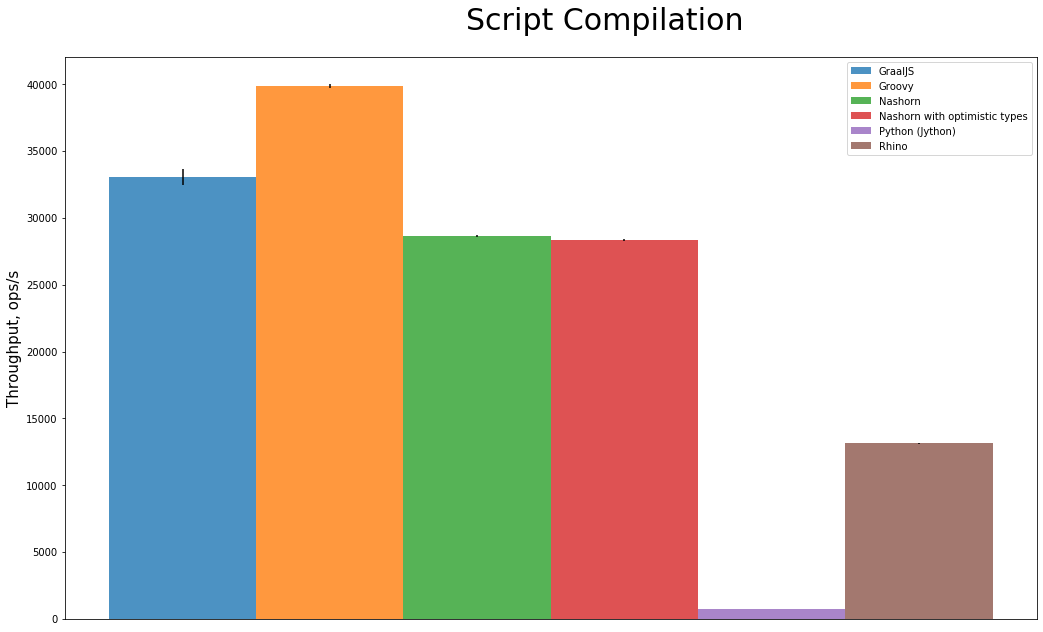

In [12]:
# compilation benchmark result plotting

bar_width = 1
opacity = 0.8

_, axis = plt.subplots(figsize=(20, 10))
plt.subplots_adjust(bottom=0.1, right=0.8)
plt.suptitle('Script Compilation', fontsize=30, y=0.95)

result_data = grouped_data["CompilationBenchmark"]

for i, result in enumerate(result_data):
    add_bar(
        axis, 
        {
            "number": i,
            "value": int(result["score"]),
            "width": bar_width,
            "characteristics": {
                "alpha": opacity, 
                "label": result["engine_case"],
                "yerr": int(result["score_error"])
            }
        }
    )
    
axis.set_ylabel('Throughput, ops/s', size=15)
axis.set_xticks([])
axis.legend()
plt.show()

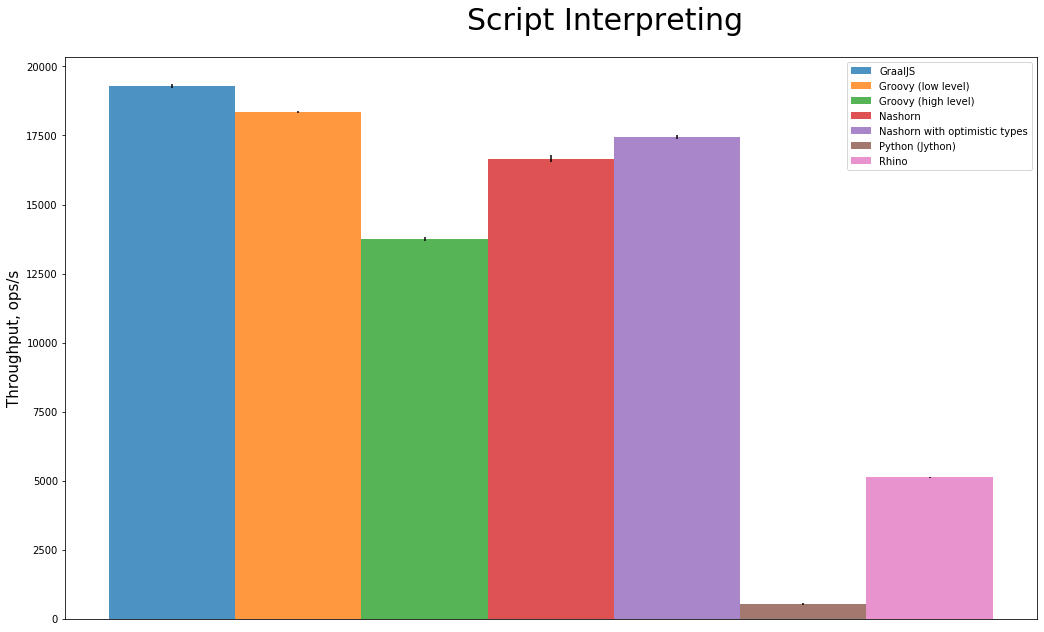

In [13]:
# interpreting benchmark result plotting

names_mapping = {
    "withForEvalScript": "Groovy (low level)",
    "withRangeEvalScript": "Groovy (high level)"
}

bar_width = 1
opacity = 0.8

_, axis = plt.subplots(figsize=(20, 10))
plt.subplots_adjust(bottom=0.1, right=0.8)
plt.suptitle('Script Interpreting', fontsize=30, y=0.95)

result_data = grouped_data["InterpretationEvalBenchmark"]
names = [
    result["engine_case"]
    if result["engine_case"] is not "Groovy"
    else names_mapping[result["benchmark_method"]]
    for result in result_data
]

for i, result in enumerate(result_data):
    add_bar(
        axis, 
        {
            "number": i,
            "value": int(result["score"]),
            "width": bar_width,
            "characteristics": {
                "alpha": opacity, 
                "label": names[i],
                "yerr": int(result["score_error"])
            }
        }
    )

axis.set_ylabel('Throughput, ops/s', size=15)
axis.set_xticks([])
axis.legend()
plt.show()

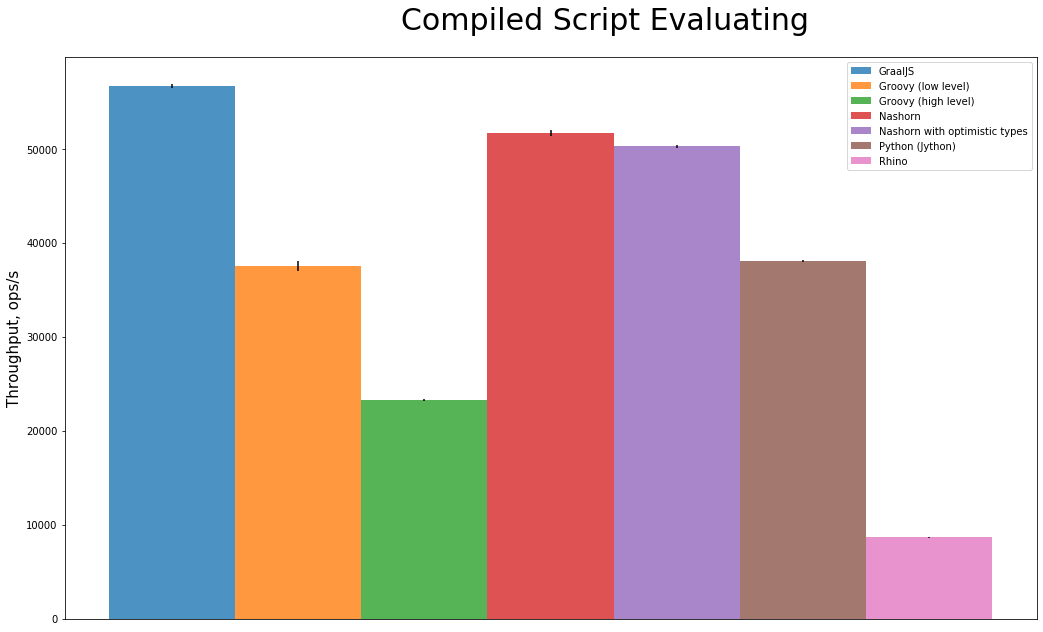

In [14]:
# compiled script evaluating benchmark result plotting

bar_width = 1
opacity = 0.8

_, axis = plt.subplots(figsize=(20, 10))
plt.subplots_adjust(bottom=0.1, right=0.8)
plt.suptitle('Compiled Script Evaluating', fontsize=30, y=0.95)

result_data = grouped_data["CompiledEvalBenchmark"]
names = [
    result["engine_case"]
    if result["engine_case"] is not "Groovy"
    else names_mapping[result["benchmark_method"]]
    for result in result_data
]

for i, result in enumerate(result_data):
    add_bar(
        axis, 
        {
            "number": i,
            "value": int(result["score"]),
            "width": bar_width,
            "characteristics": {
                "alpha": opacity, 
                "label": names[i],
                "yerr": int(result["score_error"])
            }
        }
    )
    
axis.set_ylabel('Throughput, ops/s', size=15)
axis.set_xticks([])
axis.legend()
plt.show()

In [15]:
# evaluation cases mapping to human readable names
names_mapping = {
    ("Groovy", "withForEvalScript"): "Groovy (low level)",
    ("Groovy", "withRangeEvalScript"): "Groovy (high level)",
    ("Nashorn", "evalScript"): "Nashorn",
    ("Nashorn with optimistic types", "evalScript"): "Nashorn with optimistic types",
    ("Rhino", "evalScript"): "Rhino",
    ("Python (Jython)", "evalScript"): "Python (Jython)",
    ("GraalJS", "evalScript"): "GraalJS"
}
# lambda function for group ID getting
get_engine_and_method_tuple = \
    lambda item: (item["engine_case"], item["benchmark_method"])

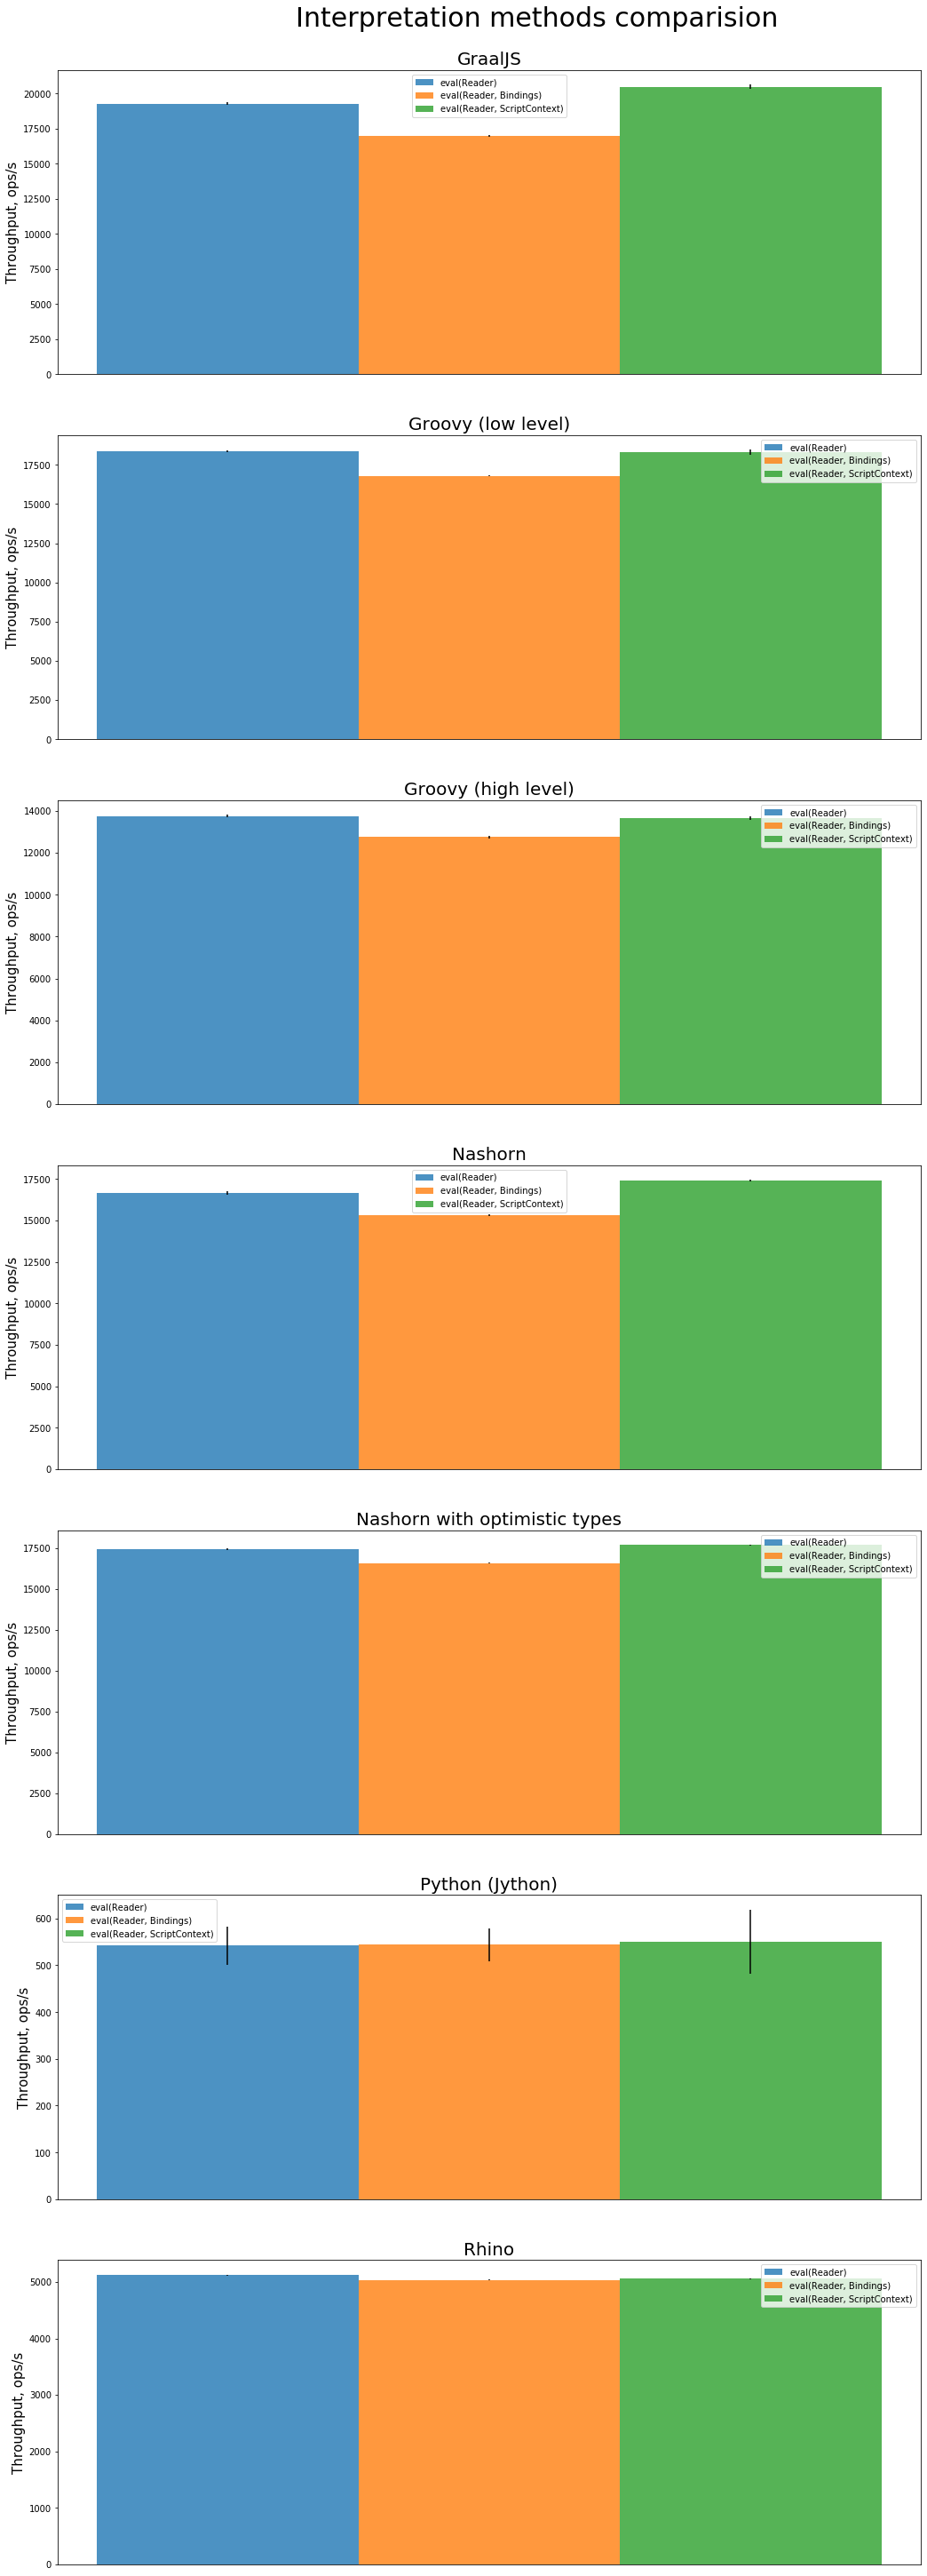

In [16]:
# interpretation methods comparision

# benchmark names mapping to human readable names
labels_mapping = {
    "InterpretationEvalBenchmark": "eval(Reader)",
    "InterpretationEvalWithBindingsBenchmark": "eval(Reader, Bindings)",
    "InterpretationEvalWithContextBenchmark": "eval(Reader, ScriptContext)",
}

# needed data extracting
result_data = {
    key: grouped_data[key]
    for key in (
        "InterpretationEvalBenchmark",
        "InterpretationEvalWithBindingsBenchmark",
        "InterpretationEvalWithContextBenchmark"
    )
}
grouped_data_for_plotting = groupby(
    sorted(
        (
            item
            for key in result_data
            for item in result_data[key]
        ),
        key=get_engine_and_method_tuple
    ),
    get_engine_and_method_tuple
)

# plotting part

bar_width = 1
opacity = 0.8

_, axes = plt.subplots(nrows=7, ncols=1, figsize=(20, 50))
plt.subplots_adjust(bottom=0.1, right=0.8)
plt.suptitle(
    'Interpretation methods comparision',
    fontsize=30, y=0.90
)

for num, case_tuple in enumerate(grouped_data_for_plotting):
    group_id, group = case_tuple
    group_list = list(group)

    for i, result in enumerate(group_list):
        add_bar(
            axes[num], 
            {
                "number": i,
                "value": int(result["score"]),
                "width": bar_width,
                "characteristics": {
                    "alpha": opacity, 
                    "label": labels_mapping[result["name"]],
                    "yerr": int(result["score_error"])
                }
            }
        )

    axes[num].set_title(names_mapping[group_id], fontsize=20)
    axes[num].set_ylabel('Throughput, ops/s', size=15)
    axes[num].set_xticks([])
    axes[num].legend()
plt.show()


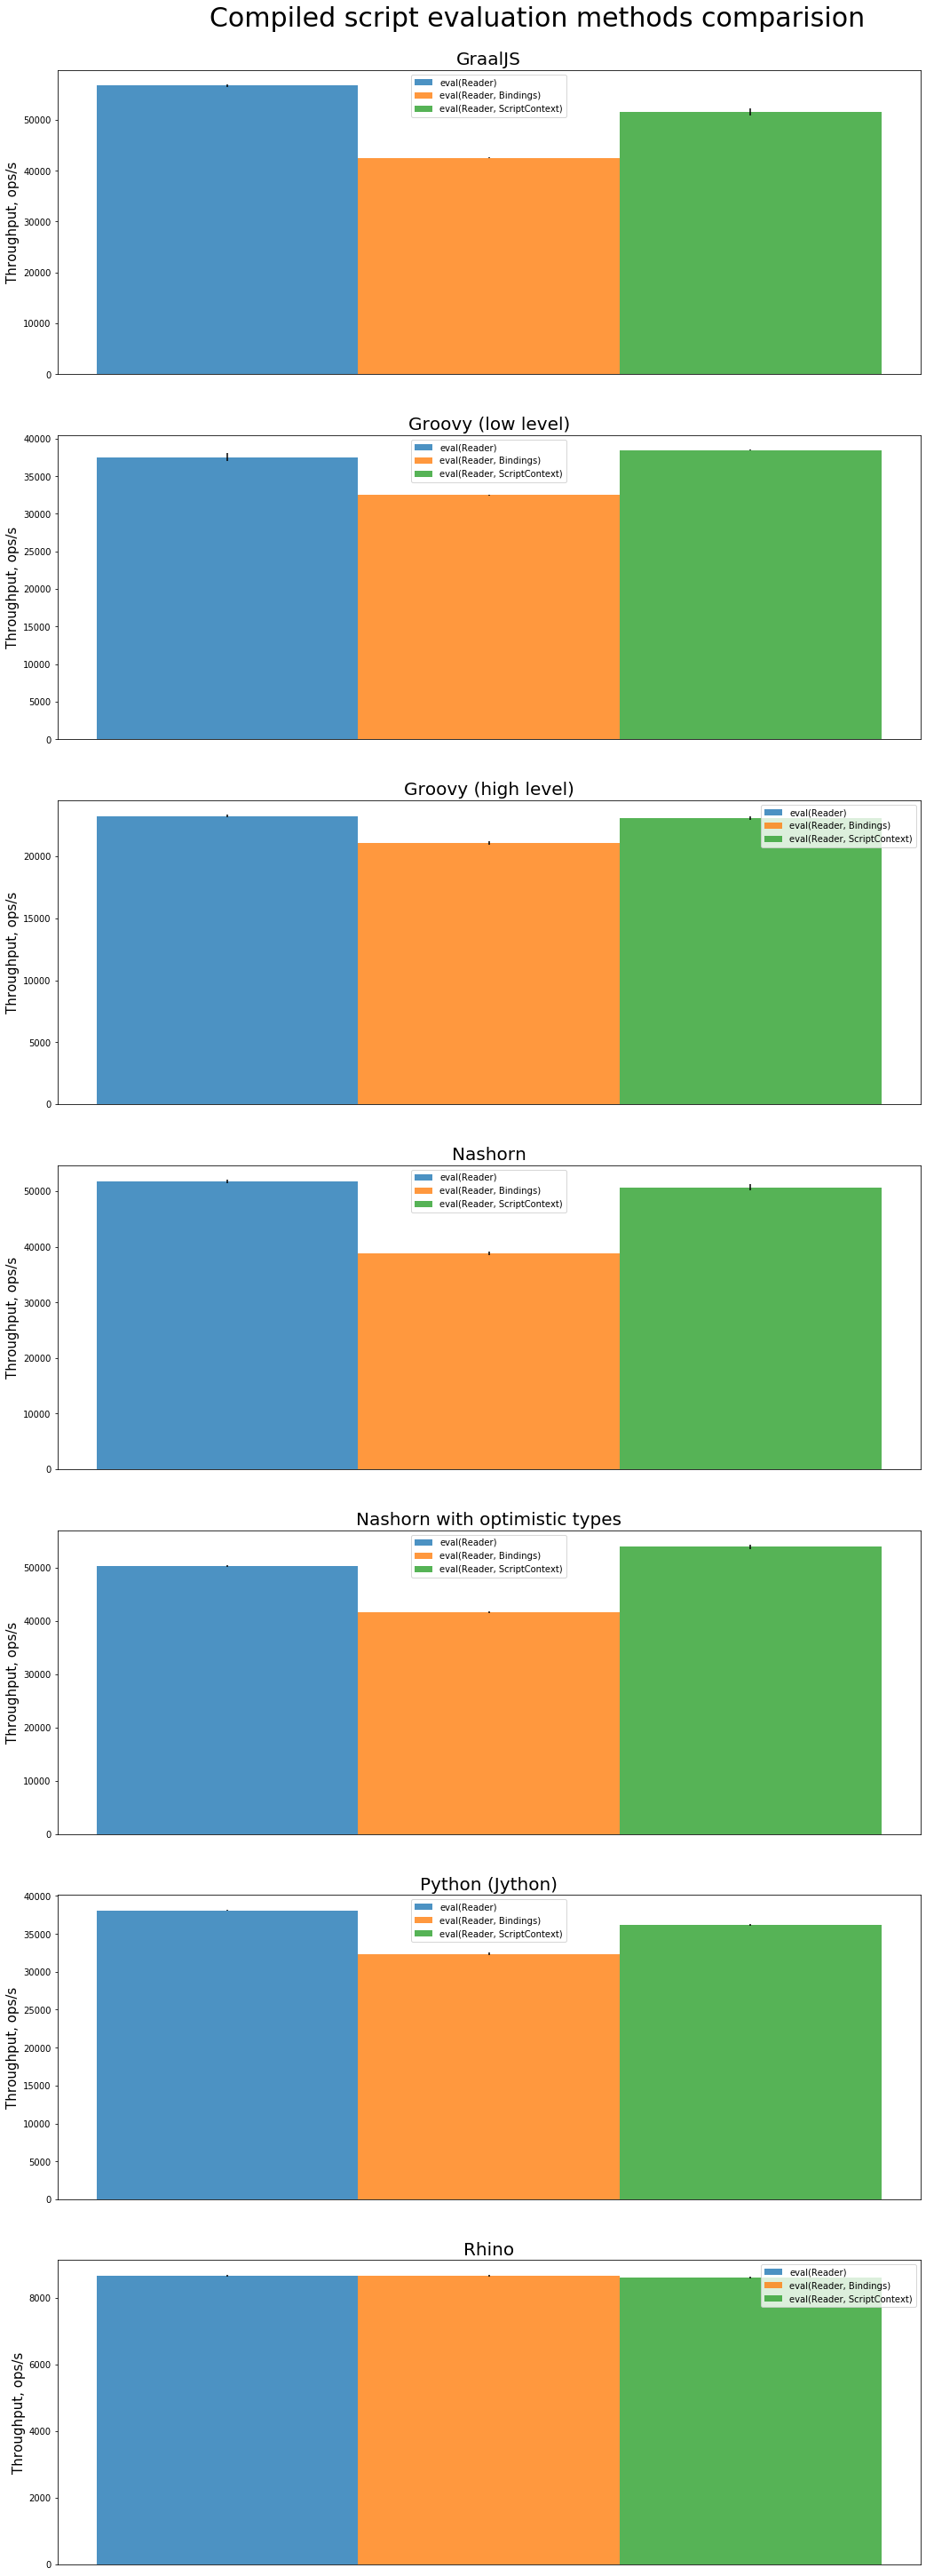

In [17]:
# compiled script evaluation methods comparision


# human readable names strings mapping
labels_mapping = {
    "CompiledEvalBenchmark": "eval(Reader)",
    "CompiledEvalWithBindingsBenchmark": "eval(Reader, Bindings)",
    "CompiledEvalWithContextBenchmark": "eval(Reader, ScriptContext)"
}

# needed data extracting
result_data = {
    key: grouped_data[key]
    for key in (
        "CompiledEvalBenchmark",
        "CompiledEvalWithBindingsBenchmark",
        "CompiledEvalWithContextBenchmark"
    )
}
grouped_data_for_plotting = groupby(
    sorted(
        (
            item
            for key in result_data
            for item in result_data[key]
        ),
        key=get_engine_and_method_tuple
    ),
    get_engine_and_method_tuple
)

# plotting part

bar_width = 1
opacity = 0.8

_, axes = plt.subplots(nrows=7, ncols=1, figsize=(20, 50))
plt.subplots_adjust(bottom=0.1, right=0.8)
plt.suptitle(
    'Compiled script evaluation methods comparision',
    fontsize=30, y=0.90
)

for num, case_tuple in enumerate(grouped_data_for_plotting):
    group_id, group = case_tuple
    group_list = list(group)

    for i, result in enumerate(group_list):
        add_bar(
            axes[num], 
            {
                "number": i,
                "value": int(result["score"]),
                "width": bar_width,
                "characteristics": {
                    "alpha": opacity, 
                    "label": labels_mapping[result["name"]],
                    "yerr": int(result["score_error"])
                }
            }
        )

    axes[num].set_title(names_mapping[group_id], fontsize=20)
    axes[num].set_ylabel('Throughput, ops/s', size=15)
    axes[num].set_xticks([])
    axes[num].legend()
plt.show()


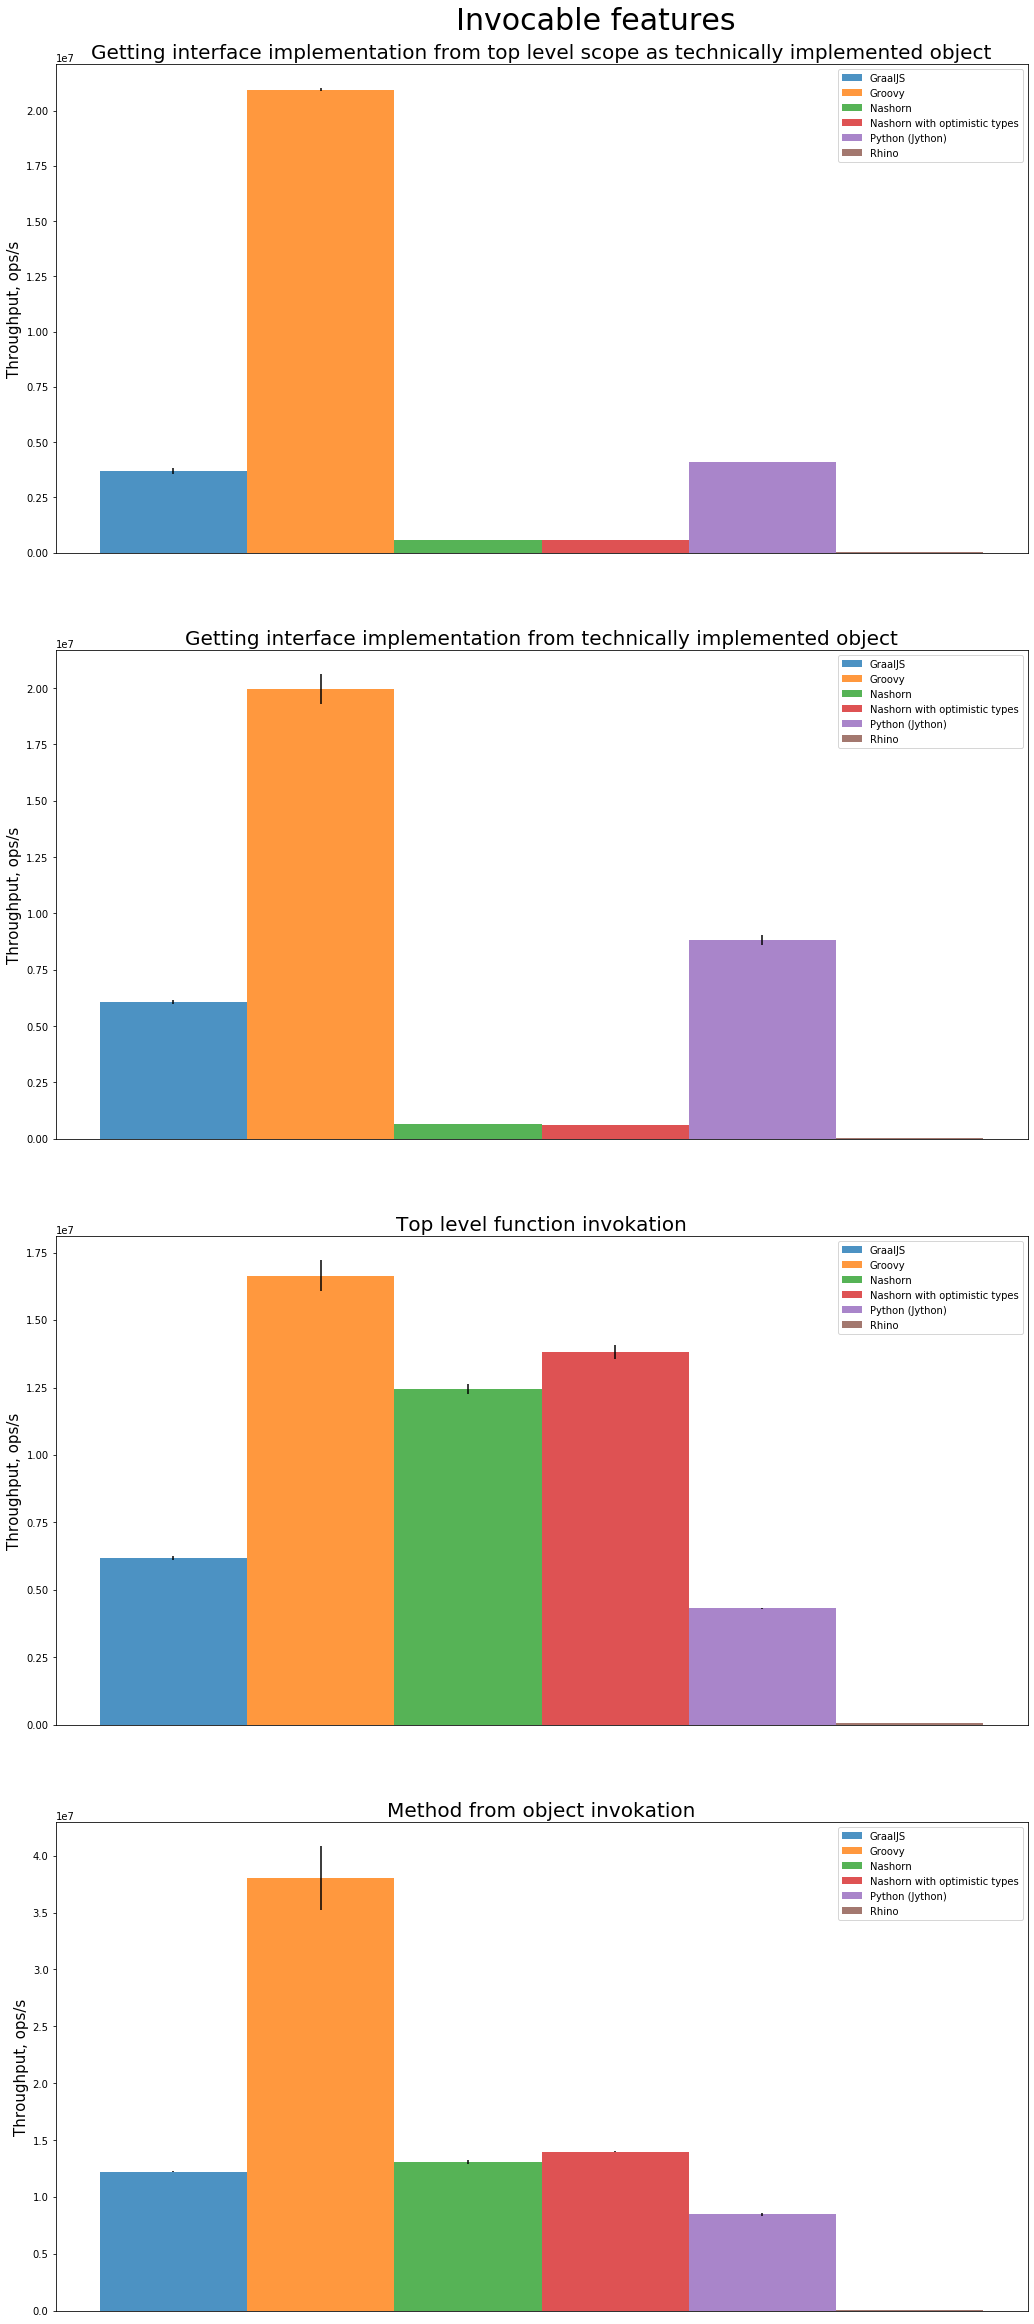

In [18]:
# invocable benchmark result plotting

names_mapping = {
    "getInterface": "Getting interface implementation "
                    "from top level scope as technically implemented object",
    "getInterfaceFromProperty": "Getting interface implementation "
                                "from technically implemented object",
    "invokeFunction": "Top level function invokation",
    "invokeMethod": "Method from object invokation"
}

bar_width = 1
opacity = 0.8

_, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 40))
plt.subplots_adjust(bottom=0.1, right=0.8)
plt.suptitle('Invocable features', fontsize=30, y=0.90)

result_data = groupby(
    sorted(
        grouped_data["EngineAsInvocableBenchmark"], 
        key=lambda data: data["benchmark_method"]
    ), 
    key=lambda data: data["benchmark_method"]
)

for num, result_pair in enumerate(result_data):
    name, group = result_pair
    group_list = list(group)
    
    for i, result in enumerate(group_list):
        add_bar(
            axes[num], 
            {
                "number": i,
                "value": int(result["score"]),
                "width": bar_width,
                "characteristics": {
                    "alpha": opacity, 
                    "label": result["engine_case"],
                    "yerr": int(result["score_error"])
                }
            }
        )
    
    axes[num].set_title(names_mapping[name], fontsize=20)
    axes[num].set_ylabel('Throughput, ops/s', size=15)
    axes[num].set_xticks([])
    axes[num].legend()
plt.show()

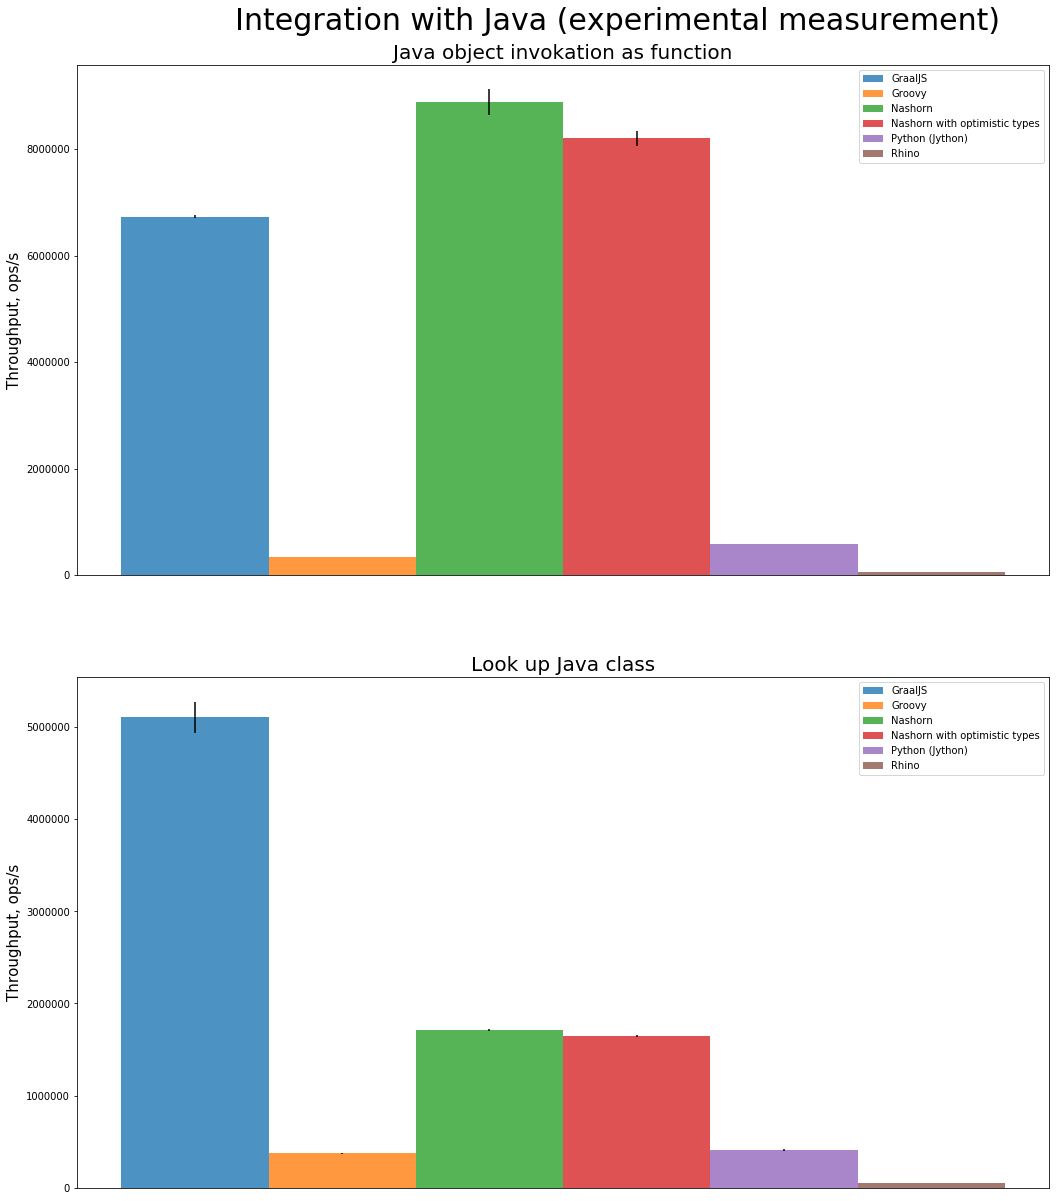

In [19]:
# experimental benchmarks result plotting (probably not acceptable)

names_mapping = {
    "InvokeObjectAsFunctionBenchmark": "Java object invokation as function",
    "LookUpClassBenchmark": "Look up Java class"
}

bar_width = 1
opacity = 0.8

_, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))
plt.subplots_adjust(bottom=0.1, right=0.8)
plt.suptitle(
    'Integration with Java (experimental measurement)', 
    fontsize=30, y=0.92
)

result_data = {
    key: grouped_data[key] 
    for key in ("InvokeObjectAsFunctionBenchmark", "LookUpClassBenchmark")
}

for num, name in enumerate(result_data):
    group = result_data[name]
    group_list = list(group)
    
    for i, result in enumerate(group_list):
        add_bar(
            axes[num], 
            {
                "number": i,
                "value": int(result["score"]),
                "width": bar_width,
                "characteristics": {
                    "alpha": opacity, 
                    "label": result["engine_case"],
                    "yerr": int(result["score_error"])
                }
            }
        )
    
    axes[num].set_title(names_mapping[name], fontsize=20)
    axes[num].set_ylabel('Throughput, ops/s', size=15)
    axes[num].set_xticks([])
    axes[num].legend()
plt.show()